In [1]:
#import lib/packages
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
import re
nltk.download("stopwords")
nltk.download("wordnet")
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\intel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\intel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#import dataset
dataset = pd.read_csv("SMSSpamCollection", sep='\t', names=['label', 'message'])
dataset['label'] = dataset['label'].map({'ham': 0, 'spam': 1})

In [3]:
# Handle class imbalance
only_spam = dataset[dataset['label'] == 1]
count = int((dataset.shape[0] - only_spam.shape[0]) / only_spam.shape[0])
for i in range(0, count-1):
    dataset = pd.concat([dataset, only_spam])    

dataset.reset_index(drop=True, inplace=True)

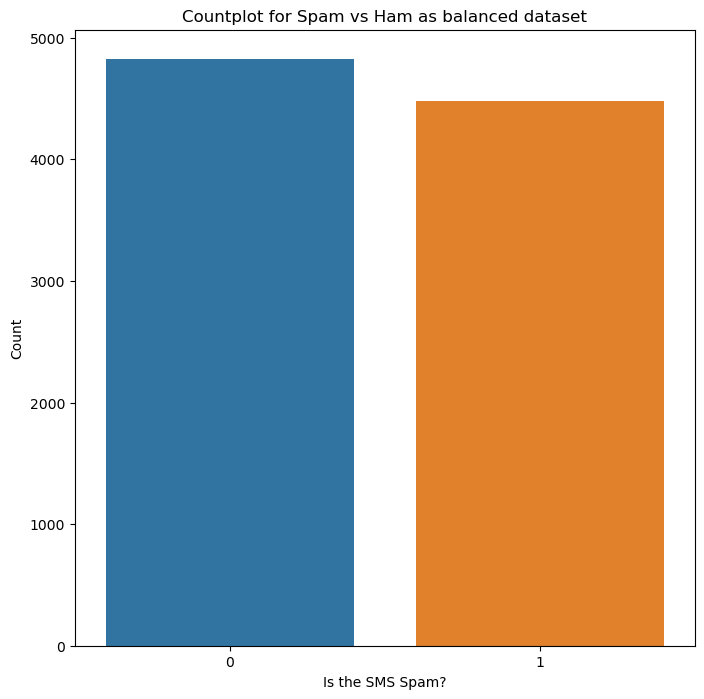

In [4]:
# Visualization
plt.figure(figsize=(8, 8))
sns.countplot(x="label", data=dataset)
plt.title('Countplot for Spam vs Ham as balanced dataset')
plt.xlabel('Is the SMS Spam?')
plt.ylabel('Count')
plt.show()

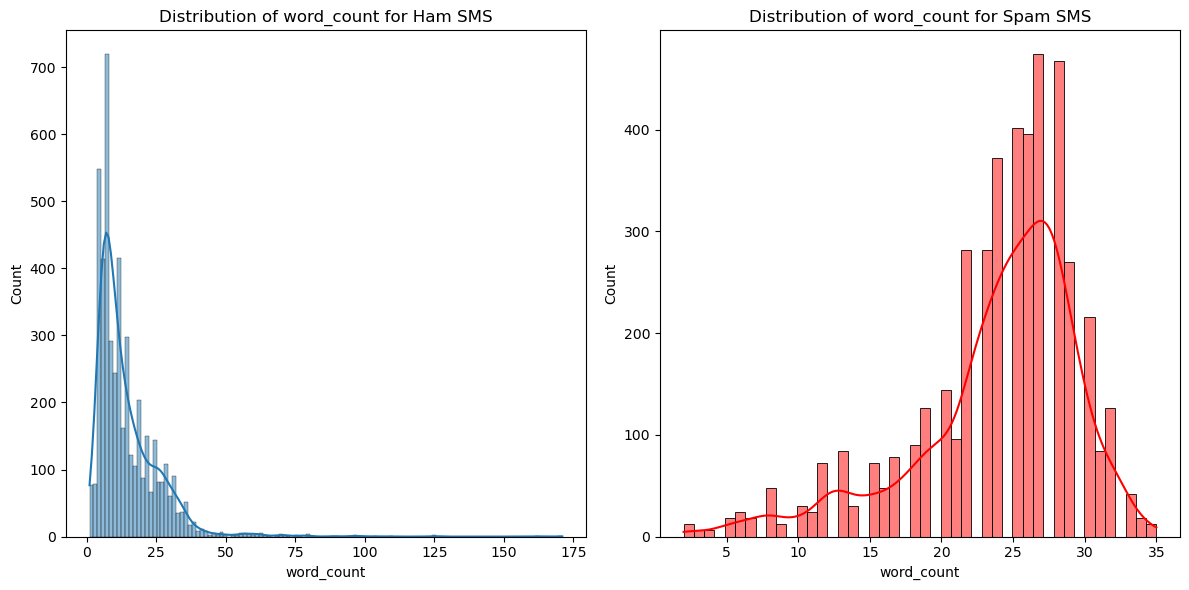

In [5]:
# Feature Engineering
dataset['word_count'] = dataset['message'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(dataset[dataset['label'] == 0].word_count, kde=True)
plt.title('Distribution of word_count for Ham SMS')
plt.subplot(1, 2, 2)
sns.histplot(dataset[dataset['label'] == 1].word_count, color="red", kde=True)
plt.title('Distribution of word_count for Spam SMS')
plt.tight_layout()
plt.show()

def currency(data):
    currency_symbols = ['€', '$', '¥', '£', '₹']
    for i in currency_symbols:
        if i in data:
            return 1
    return 0

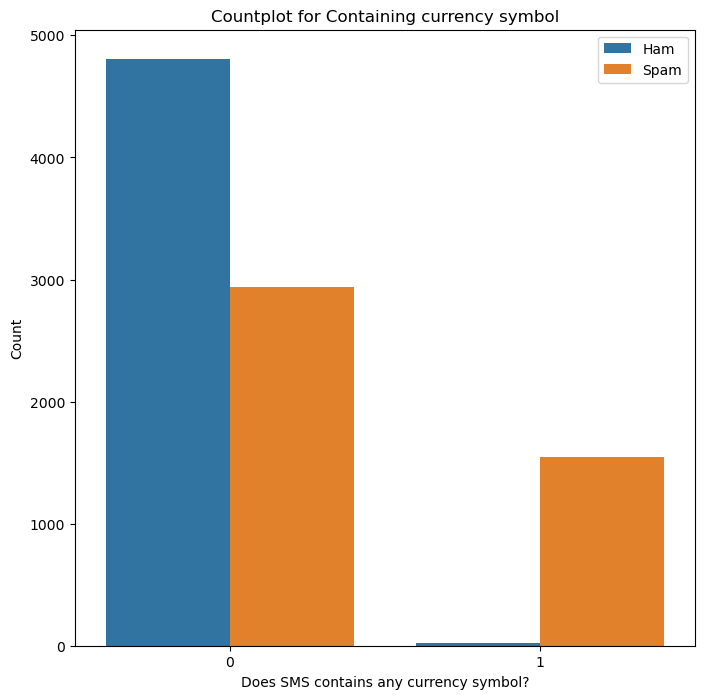

In [6]:
dataset["contains_currency_symbol"] = dataset["message"].apply(currency)

plt.figure(figsize=(8, 8))
sns.countplot(x="contains_currency_symbol", data=dataset, hue="label")
plt.title('Countplot for Containing currency symbol')
plt.xlabel('Does SMS contains any currency symbol?')
plt.ylabel('Count')
plt.legend(labels=['Ham', 'Spam'], loc='best')
plt.show()

def number(data):
    for i in data:
        if ord(i) >= 48 and ord(i) <= 57:
            return 1
    return 0

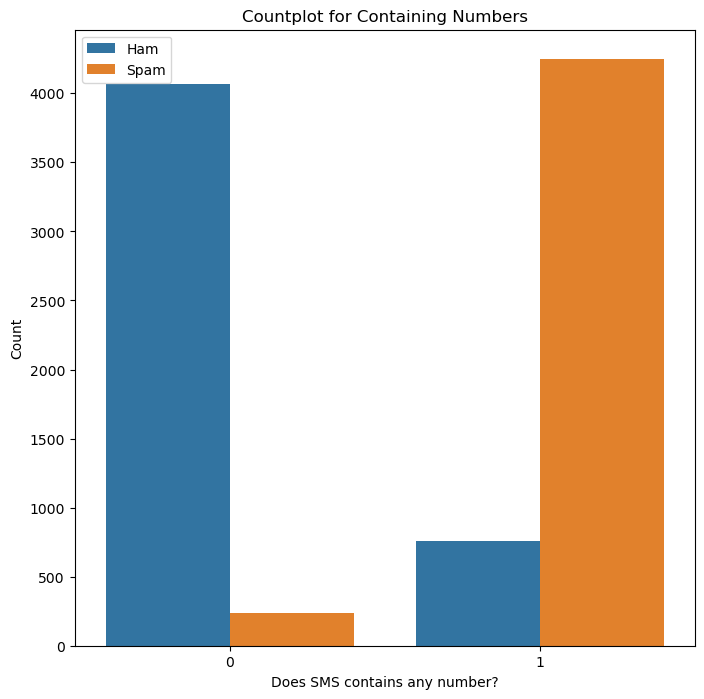

In [7]:
dataset["contains_number"] = dataset["message"].apply(number)

plt.figure(figsize=(8, 8))
sns.countplot(x="contains_number", data=dataset, hue="label")
plt.title('Countplot for Containing Numbers')
plt.xlabel('Does SMS contains any number?')
plt.ylabel('Count')
plt.legend(labels=['Ham', 'Spam'], loc='best')
plt.show()

In [8]:
# Text Preprocessing
corpus = []
wnl = WordNetLemmatizer()

for sms in dataset.message:
    message = re.sub(pattern='[^a-zA-Z]', repl=' ', string=sms)
    message = message.lower()
    words = message.split()
    filtered_words = [word for word in words if word not in set(stopwords.words('english'))]
    lemm_words = [wnl.lemmatize(word) for word in filtered_words]
    message = ' '.join(lemm_words)
    corpus.append(message)

In [9]:
# Creating the Bag of words model
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=500)
vectors = tfidf.fit_transform(corpus).toarray()
feature_names = tfidf.get_feature_names_out()
X = pd.DataFrame(vectors, columns=feature_names)
y = dataset['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [10]:
# Naive Bayes Model
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred_nb = mnb.predict(X_test)

In [11]:
# Random Forest Model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [12]:
# Evaluation of Naive Bayes Model
print("Naive Bayes Model Evaluation")
print("-----------------------------")
print("Classification Report:")
print(classification_report(y_test, y_pred_nb))
print("\n")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb))
print("\n")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))

Naive Bayes Model Evaluation
-----------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       965
           1       0.93      0.95      0.94       897

    accuracy                           0.94      1862
   macro avg       0.94      0.94      0.94      1862
weighted avg       0.94      0.94      0.94      1862



Confusion Matrix:
[[903  62]
 [ 46 851]]


Accuracy: 0.9419978517722879


In [13]:
# Evaluation of Random Forest Model
print("Random Forest Model Evaluation")
print("--------------------------------")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("\n")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("\n")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Model Evaluation
--------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       965
           1       0.99      1.00      1.00       897

    accuracy                           1.00      1862
   macro avg       1.00      1.00      1.00      1862
weighted avg       1.00      1.00      1.00      1862



Confusion Matrix:
[[959   6]
 [  2 895]]


Accuracy: 0.9957035445757251


In [19]:
import joblib

# Save the models and vectorizer
joblib.dump(mnb, 'D:/spam_detection/model/naive_bayes_model.pkl')
joblib.dump(rf, 'D:/spam_detection/model/random_forest_model.pkl')
joblib.dump(tfidf, 'D:/spam_detection/model/tfidf_vectorizer.pkl')


['D:/spam_detection/model/tfidf_vectorizer.pkl']